# Testing
### Daten der Bevölkerungsbefragung der Stadt Zürich 1999 bis 2021
Datum: 10.12.2021

### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [6]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [7]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 9 datenstand:  7 time.struct_time(tm_year=2022, tm_mon=9, tm_mday=27, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=270, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [8]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [9]:
package_name = "prd_stez_bevoelkerungsbefragungen_seit1999_od4731"

In [10]:
dataset_name = "BEV473OD4731.csv"
metadata_name ="codeliste_bvb_ogd.csv"

**Statische Pfade in DWH-Dropzones**

In [11]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [12]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [13]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [14]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [15]:
from IPython.display import Markdown as md

In [16]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_prd_stez_bevoelkerungsbefragungen_seit1999_od4731 

In [17]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/prd_stez_bevoelkerungsbefragungen_seit1999_od4731 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [18]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "dropzone"; #dropzone vs something else
print(status+" - "+ data_source)

prod - dropzone


In [19]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            fp_meta = dropzone_path_prod+"\\"+ package_name +"\\"+metadata_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        fp_meta = ckan_prod_url+package_name+'/download/'+metadata_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        fp_meta = dropzone_path_integ+"\\"+ package_name +"\\"+metadata_name      
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        fp_meta = dropzone_path_integ+"\\"+ package_name +"\\"+metadata_name       
        print("fp lautet:"+fp)


fp lautet:\\szh\ssz\applikationen\OGD_Dropzone\DWH\prd_stez_bevoelkerungsbefragungen_seit1999_od4731\BEV473OD4731.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [20]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['Jahr']
        , encoding = "UTF-8"
        ,low_memory=False
    )
    
    meta2betested = pd.read_csv(
        fp_meta
        , sep=','
        , encoding = "UTF-8"
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['Jahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    
    r = requests.get(fp_meta, verify=False)  
    r.encoding = 'utf-8'
    meta2betested = pd.read_csv(
        io.StringIO(r.text)
        ,low_memory=False)
    
       
    print("web")

#data2betested.dtypes

dropzone


In [21]:
meta2betested

,Code,Beschreibung,Variable,Frage,Titel
0,1,Überhaupt nicht sinnvoll,A1027aa01,S10,Sinnhaftigkeit Bevölkerungsbefragung
1,2,Wenig sinnvoll,A1027aa01,S10,Sinnhaftigkeit Bevölkerungsbefragung
2,3,Sinnvoll,A1027aa01,S10,Sinnhaftigkeit Bevölkerungsbefragung
3,4,Sehr sinnvoll,A1027aa01,S10,Sinnhaftigkeit Bevölkerungsbefragung
4,99,Keine Angabe,A1027aa01,S10,Sinnhaftigkeit Bevölkerungsbefragung
...,...,...,...,...,...
5007,2,V2,fbversion,Fragebogenversion,Fragebogenversion
5008,99,Keine Angabe,fbversion,Fragebogenversion,Fragebogenversion
5009,1,Cati,methode,Methode,Methode
5010,2,Online,methode,Methode,Methode


#### Parsing & Formatting Strings to Dataframes
- [**Cheat Sheet**](https://strftime.org/)
- Python documentation for **strptime**: [string **parse** time, Python 3](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime)
- Python documentation for strptime/**strftime**: [string **format** time,Python 3](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)



Berechne weitere Attribute falls notwendig

In [22]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        Jahr_str = lambda x: x.Jahr.astype(str),
    )
    .sort_values('Jahr', ascending=False)
    )
data2betested.dtypes

Jahr         datetime64[ns]
intnr                 int64
methode              object
fbversion            object
sgewicht            float64
                  ...      
A9005aa01            object
A9005ab01            object
A9005ac01            object
A1027aa01            object
Jahr_str             object
Length: 361, dtype: object

In der Folge ein paar erste Tests:

In [23]:
data2betested.head(3)

,Jahr,intnr,methode,fbversion,sgewicht,pgewicht,schichtCd,...,A9003aa01,A9004aa01,A9005aa01,A9005ab01,A9005ac01,A1027aa01,Jahr_str
33751,2021-01-01,1113034,Papier,Keine Angabe,1,87,845,...,Eher locker bebaut,Gerade richtig,Keine Angabe,Trifft eher zu,Keine Angabe,Sinnvoll,2021-01-01
30166,2021-01-01,1110563,Online,Keine Angabe,1,47,1005,...,Eher locker bebaut,Gerade richtig,Trifft eher zu,Trifft überhaupt nicht zu,Trifft eher nicht zu,Sinnvoll,2021-01-01
30158,2021-01-01,1111573,Online,Keine Angabe,1,84,713,...,Eher locker bebaut,Gerade richtig,Trifft sehr zu,Trifft eher nicht zu,Trifft eher zu,Sinnvoll,2021-01-01


In [24]:
data2betested.shape

(33752, 361)

Beschreibe einzelne Attribute

In [25]:
data2betested.describe()

,intnr,sgewicht,pgewicht,schichtCd
count,33752,33752,33752,33752
mean,7577148,1,98,1405
std,4417919,0,37,3073
min,1101,0,2,11
25%,1113322,1,70,103
50%,10304966,1,97,203
75%,10710466,1,124,709
max,10919103,6,696,9999


Wie viele Nullwerte gibt es im Datensatz?

In [26]:
data2betested.isnull().sum()

Jahr         0
intnr        0
methode      0
fbversion    0
sgewicht     0
            ..
A9005aa01    0
A9005ab01    0
A9005ac01    0
A1027aa01    0
Jahr_str     0
Length: 361, dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [27]:
data2betested = data2betested.set_index("Jahr")

In [28]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33752 entries, 2021-01-01 to 1999-01-01
Columns: 360 entries, intnr to Jahr_str
dtypes: float64(2), int64(2), object(356)
memory usage: 93.0+ MB


Int64Index([2021, 2019, 2015, 2013, 2011, 2009, 2007, 2005, 2003, 2001, 1999], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [29]:
#from pivottablejs import pivot_ui

#pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [30]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,intnr,methode,fbversion,sgewicht,pgewicht,schichtCd,A1BVSKreis01,...,A9003aa01,A9004aa01,A9005aa01,A9005ab01,A9005ac01,A1027aa01,Jahr_str
Jahr,,,,,,,,,,,,,,,
2009-01-01,10611719,Cati,Keine Angabe,1,119,191,Kreis 11,...,Keine Angabe,Keine Angabe,Keine Angabe,Keine Angabe,Keine Angabe,Wenig sinnvoll,2009-01-01
2009-01-01,10611906,Cati,Keine Angabe,1,149,163,Kreis 9,...,Keine Angabe,Keine Angabe,Keine Angabe,Keine Angabe,Keine Angabe,Sinnvoll,2009-01-01


### Visualisierungen nach Zeitausschnitten

In [31]:
#data2betested.columns

In [32]:
frage_A9004aa01 = data2betested["2019"].groupby(['Jahr', 'intnr', 'methode','fbversion'])[['sgewicht']].sum().sort_values('sgewicht', ascending=False)
frage_A9004aa01

sgewicht
Jahr       intnr   methode fbversion             
2019-01-01 1102595 Online  Keine Angabe         2
           1104831 Papier  Keine Angabe         2
           1102087 Online  Keine Angabe         2
           1105056 Papier  Keine Angabe         2
           1101567 Online  Keine Angabe         2
...                                           ...
           1103548 Online  Keine Angabe         0
           1105165 Papier  Keine Angabe         0
           110104  Online  Keine Angabe         0
           110826  Online  Keine Angabe         0
           1101693 Online  Keine Angabe         0

[5117 rows x 1 columns]

#### Wusel Gusel

In [33]:
meta2betested.columns

Index(['Code', 'Beschreibung', 'Variable', 'Frage', 'Titel'], dtype='object')

In [34]:
#Scanne durch die Auswahl von FXY durch die Fragen
meta2betested.query('Frage =="F29"').head(30).sort_values('Variable', ascending = False)

,Code,Beschreibung,Variable,Frage,Titel
3676,1,Ja,A4003aa01,F29,"Meidung Orte in der Stadt, ausserhalb Quartier"
3677,2,Nein,A4003aa01,F29,"Meidung Orte in der Stadt, ausserhalb Quartier"
3678,3,Bin nachts nie allein unterwegs,A4003aa01,F29,"Meidung Orte in der Stadt, ausserhalb Quartier"
3679,99,Keine Angabe,A4003aa01,F29,"Meidung Orte in der Stadt, ausserhalb Quartier"


In [35]:
data2betested.columns

Index(['intnr', 'methode', 'fbversion', 'sgewicht', 'pgewicht', 'schichtCd', 'A1BVSKreis01',
       'A1BVSSex01', 'A2001aa01', 'A2002aa01',
       ...
       'A9001ad01', 'A9001ae01', 'A9002aa01', 'A9003aa01', 'A9004aa01', 'A9005aa01', 'A9005ab01',
       'A9005ac01', 'A1027aa01', 'Jahr_str'],
      dtype='object', length=360)

In [36]:
#mit Kreisen 'A1BVSKreis01',
myAgg = data2betested.loc["2009":"2021"]\
    .groupby(['Jahr', 'A3009aa01','fbversion']) \
    .agg(sum_sgewicht=('sgewicht', 'sum')) \
    .sort_values('sum_sgewicht', ascending=False) 

myAgg.reset_index().head(3)

,Jahr,A3009aa01,fbversion,sum_sgewicht
0,2021-01-01,Angemessen,Keine Angabe,2059
1,2019-01-01,Angemessen,Keine Angabe,2030
2,2015-01-01,Angemessen,Keine Angabe,1515


In [37]:
myTitle="Frage 20: Mietzins im Vergleich zur Wohnungsqualität 2021 "

highlight = alt.selection(type='single', on='mouseover',
                          fields=['A3009aa01'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_sgewicht>0'), title=myTitle).encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_sgewicht', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('A3009aa01', legend=alt.Legend(title="Antwort", orient="right"))  
    ,tooltip=['Jahr', 'A3009aa01','sum_sgewicht']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

### Entwicklung Sicherheit

In [38]:
#mit Kreisen 'A1BVSKreis01',
myAgg = data2betested.loc["2009":"2021"]\
    .groupby(['Jahr', 'A4003aa01','fbversion']) \
    .agg(sum_sgewicht=('sgewicht', 'sum')) \
    .sort_values('sum_sgewicht', ascending=False) 

myAgg.reset_index().head(3)

,Jahr,A4003aa01,fbversion,sum_sgewicht
0,2019-01-01,Nein,Keine Angabe,2507
1,2021-01-01,Nein,Keine Angabe,2447
2,2021-01-01,Ja,Keine Angabe,2188


In [39]:
myTitle="Frage 29: Meidung Orte in der Stadt, ausserhalb Quartier"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['A4003aa01'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_sgewicht>0'), title=myTitle).encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_sgewicht', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('A4003aa01', legend=alt.Legend(title="Antwort", orient="right"))  
    ,tooltip=['Jahr', 'A4003aa01','sum_sgewicht']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [40]:
#mit Kreisen 'A1BVSKreis01',
myAggBar = data2betested.loc["2009":"2021"]\
    .groupby(['Jahr', 'A1BVSKreis01','A4003aa01','fbversion']) \
    .agg(sum_sgewicht=('sgewicht', 'sum')) \
    .sort_values('sum_sgewicht', ascending=False) 

myAggBar.reset_index().head(3)

,Jahr,A1BVSKreis01,A4003aa01,fbversion,sum_sgewicht
0,2019-01-01,Kreis 11,Ja,Keine Angabe,400
1,2021-01-01,Kreis 11,Ja,Keine Angabe,380
2,2021-01-01,Kreis 11,Nein,Keine Angabe,375


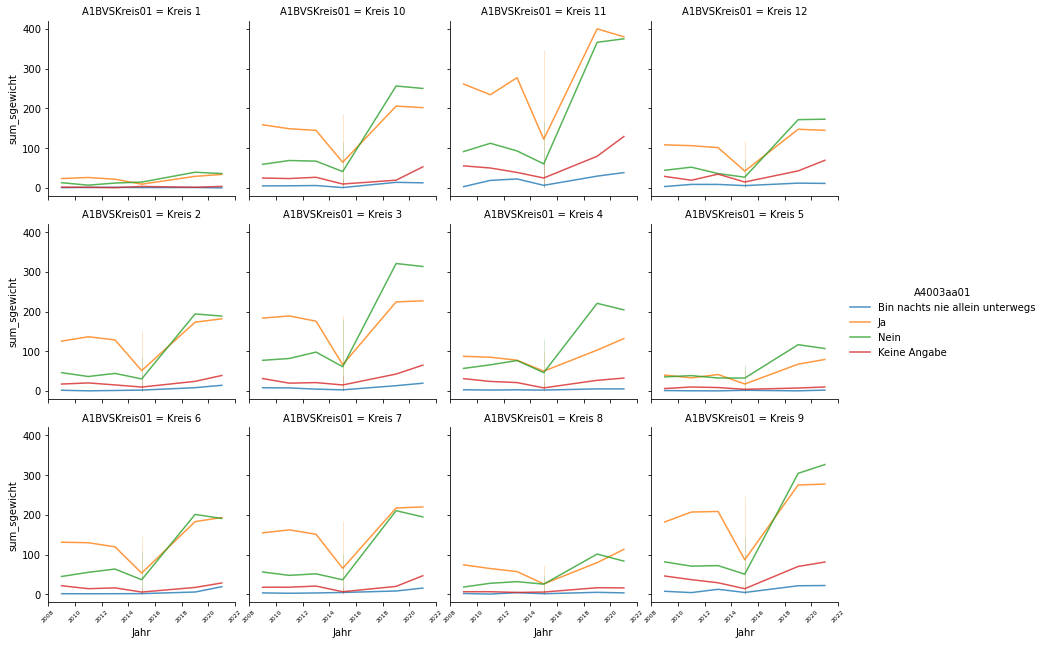

In [41]:
g2 = sns.FacetGrid(myAggBar.reset_index().sort_values('A1BVSKreis01',ascending=True), col="A1BVSKreis01", hue="A4003aa01", col_wrap=4, height=3,)
g2.map(sns.lineplot, "Jahr","sum_sgewicht",alpha=.8)

g2.set_xticklabels(rotation=45, fontsize=6) 
g2.add_legend()

In [42]:
test=data2betested.loc["2021"]\
    .groupby(['A1BVSKreis01']) \
    .agg(sum_sgewicht=('sgewicht', 'sum')) \
    .sort_values('A1BVSKreis01', ascending=False) 

test.reset_index()

,A1BVSKreis01,sum_sgewicht
0,Kreis 9,708
1,Kreis 8,218
2,Kreis 7,478
3,Kreis 6,433
4,Kreis 5,201
5,Kreis 4,376
6,Kreis 3,627
7,Kreis 2,426
8,Kreis 12,399
9,Kreis 11,924


In [43]:
#mit Kreisen 'A1BVSKreis01',
myAggBar2 = data2betested.loc["2009":"2021"]\
    .groupby(['Jahr','A1BVSKreis01', 'A3009aa01','fbversion']) \
    .agg(sum_sgewicht=('sgewicht', 'sum')) \
    .sort_values('sum_sgewicht', ascending=False) 

myAggBar2.reset_index().head(3)

,Jahr,A1BVSKreis01,A3009aa01,fbversion,sum_sgewicht
0,2021-01-01,Kreis 11,Angemessen,Keine Angabe,387
1,2019-01-01,Kreis 11,Angemessen,Keine Angabe,360
2,2021-01-01,Kreis 9,Angemessen,Keine Angabe,299


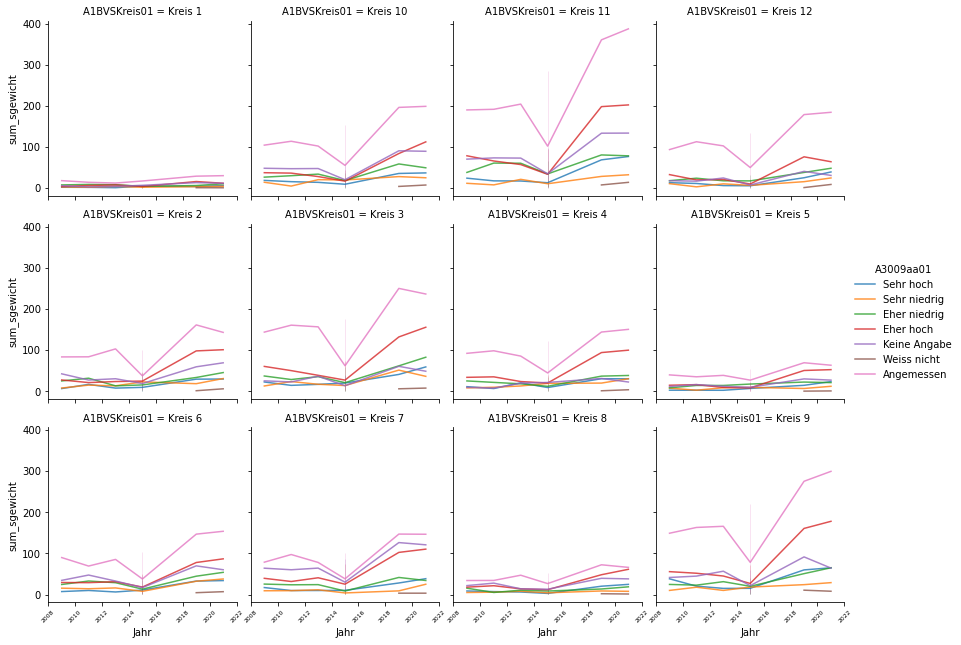

In [44]:
#myTitle="Frage 20: Mietzins im Vergleich zur Wohnungsqualität 2021 "
g3 = sns.FacetGrid(myAggBar2.reset_index().sort_values('A1BVSKreis01',ascending=True), col="A1BVSKreis01", hue="A3009aa01", col_wrap=4, height=3,)
g3.map(sns.lineplot, "Jahr","sum_sgewicht",alpha=.8)

g3.set_xticklabels(rotation=45, fontsize=6) 
g3.add_legend()

----------------------------------------------------------